# Comparing 3' ends for ONT DRS and Helicos Bio

Code for making Figure 2 in the Nanopore DRS paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. For this figure we're focussing on two sets of data; first, four biological replicates of WT col-0 tissue sequenced with ONT Direct RNA Sequencing and second, the combined data from a set of three biological replicates of WT col-0 tissue sequenced with Helicos Bio poly-A data that was used to identify poly-A positions with ~bp resolution in Sherstnev et. al. 2012.

This figure is here to illuminate the capability of ONT DRS data to reliably identify the 3' ends and poly-A position of mRNAs.

In [1]:
import re, os, sys, pysam, numpy, json, matplotlib, shutil
%matplotlib inline
import matplotlib.pyplot as plt
from parsing_routines.wig_tools import wigData, mathWigs

In [2]:
# ONT Datasets
ONT_DRS_fwd = {"col0_rep1":{"bigwig":"201901_col0_2916_fwd_three-prime.bigwig",
                            "path":"../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
             "col0_rep2a":{"bigwig":"201903_col0_2917_exp2_fwd_three-prime.bigwig",
                           "path":"../../datasets/20180405_FAH59362_WT_Col0_2917"},
             "col0_rep2b":{"bigwig":"201901_col0_2917_fwd_three-prime.bigwig",
                           "path":"../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
             "col0_rep3":{"bigwig":"201901_col0_2918_fwd_three-prime.bigwig",
                          "path":"../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
             "col0_rep4":{"bigwig":"201901_col0_2919_fwd_three-prime.bigwig",
                          "path":"../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"}}

ONT_DRS_rev = {"col0_rep1":{"bigwig":"201901_col0_2916_rev_three-prime.bigwig",
                            "path":"../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
               "col0_rep2a":{"bigwig":"201903_col0_2917_exp2_rev_three-prime.bigwig",
                             "path":"../../datasets/20180405_FAH59362_WT_Col0_2917"},
               "col0_rep2b":{"bigwig":"201901_col0_2917_rev_three-prime.bigwig",
                             "path":"../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
               "col0_rep3":{"bigwig":"201901_col0_2918_rev_three-prime.bigwig",
                            "path":"../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
               "col0_rep4":{"bigwig":"201901_col0_2919_rev_three-prime.bigwig",
                            "path":"../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"}}

# Helicos Bio datasets
HB_data_root = "../../supporting_datasets/Sherstnev2012_Helicos_Bio/"
HB_DRS_fwd = "fwd_wt1_HQ2.wig.gz"
HB_DRS_rev = "rev_wt1_HQ2.wig.gz"

datadic = {"fwd":{"Helicos DRS":wigData(os.path.join(HB_data_root, HB_DRS_fwd))},
           "rev":{"Helicos DRS":wigData(os.path.join(HB_data_root, HB_DRS_rev))}}

bigWigToWig_binary = '../../pipeline/external_tools/bigWigToWig'
fwd_ONT_wigdata = None
for keystr in ONT_DRS_fwd.keys():
    fullpath = os.path.join(ONT_DRS_fwd[keystr]["path"], "aligned_data/TAIR10/",
                            ONT_DRS_fwd[keystr]["bigwig"])
    print("Reading {}...".format(fullpath))
    thisdata  = wigData(fullpath, isBigWig=True, bigWigToWig_binary=bigWigToWig_binary)
    if fwd_ONT_wigdata is None:
        fwd_ONT_wigdata = thisdata
    else:
        fwd_ONT_wigdata = mathWigs(fwd_ONT_wigdata, thisdata)

datadic["fwd"]["ONT DRS"] = fwd_ONT_wigdata

rev_ONT_wigdata = None
for keystr in ONT_DRS_rev.keys():
    fullpath = os.path.join(ONT_DRS_rev[keystr]["path"], "aligned_data/TAIR10/",
                            ONT_DRS_rev[keystr]["bigwig"])
    print("Reading {}...".format(fullpath))
    thisdata  = wigData(fullpath, isBigWig=True, bigWigToWig_binary=bigWigToWig_binary)
    if rev_ONT_wigdata is None:
        rev_ONT_wigdata = thisdata
    else:
        rev_ONT_wigdata = mathWigs(rev_ONT_wigdata, thisdata)

datadic["rev"]["ONT DRS"] = rev_ONT_wigdata
os.unlink(os.path.join(os.getcwd(),"out.wig")) # remove irritating intermediate file ;)

Reading ../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/201901_col0_2916_fwd_three-prime.bigwig...
Reading ../../datasets/2020180405_FAH59362_WT_Col0_2917/aligned_data/TAIR10/201903_col0_2917_exp2_fwd_three-prime.bigwig...
Reading ../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/TAIR10/201901_col0_2917_fwd_three-prime.bigwig...
Reading ../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/TAIR10/201901_col0_2919_fwd_three-prime.bigwig...
Reading ../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/201901_col0_2916_rev_three-prime.bigwig...
Reading ../../datasets/2020180405_FAH59362_WT_Col0_2917/aligned_data/TAIR10/201903_col0_2917_exp2_rev_three-prime.bigwig...
Reading ../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/201901_col0_2918_rev_three-prime.bigwig...
Reading ../../datasets/20180418_1428_20180418_FAH83552_mRN

In [3]:
def notallzeroIndex(x, y):
    x_index = x==0
    y_index = y==0
    index = ~(x_index*y_index)
    return(index)

def findNearestDRS(positions, npdata, drsdata, npcountthreshold=0, drscountthreshold=0):
    np_index = numpy.where(npdata>npcountthreshold)[0]
    drs_index = numpy.where(drsdata>drscountthreshold)[0]
    nearest_drs_deltas=[]
    for pos in np_index:
        exact = numpy.where(drs_index==pos)
        if len(exact[0])==1:
            nearest_drs_deltas.append(0)
        else:
            nextup = numpy.where(drs_index>pos)[0]
            nextdown = numpy.where(drs_index<pos)[0]
            
            up_delta = None
            if len(nextup)>0:
                up_delta = drs_index[nextup[0]]-pos
            
            down_delta = None
            if len(nextdown)>0:
                down_delta = drs_index[nextdown[-1]]-pos
            
            if up_delta is not None and down_delta is not None:
                if abs(up_delta)>abs(down_delta):
                    nearest_drs_deltas.append(down_delta)
                    #if abs(down_delta)>1500:
                        #print("called down: ", pos, positions[pos], up_delta, positions[pos+up_delta], down_delta, positions[pos+down_delta], npdata[pos], drsdata[pos+up_delta])
                else:
                    nearest_drs_deltas.append(up_delta)
                    #if abs(up_delta)>1500:
                        #print("called down: ", pos, positions[pos], up_delta, positions[pos+up_delta], down_delta, positions[pos+down_delta], npdata[pos], drsdata[pos+up_delta])
            elif up_delta is not None:
                nearest_drs_deltas.append(up_delta)
            elif down_delta is not None:
                nearest_drs_deltas.append(down_delta)
    return(numpy.array(nearest_drs_deltas))

In [4]:
deltas = None
cthresh=2
for strand in datadic.keys():
    thisONTdata = datadic[strand]["ONT DRS"]
    thisHELdata = datadic[strand]["Helicos DRS"]
    for chr in thisONTdata.tracks.keys():
        if "Chr{}".format(chr) in thisHELdata.tracks.keys():
            print("Analysing deltas for {s} strand, {ch} and Chr{ch}...".format(ch=chr, s=strand))
            thisONTdata.set_region(chr)
            thisHELdata.set_region("Chr{}".format(chr))
            x=thisONTdata.get_region_data()
            y=thisHELdata.get_region_data()
            full_y = numpy.zeros(len(x[1]))
            full_y[y[0]]=y[1]
            index = notallzeroIndex(x[1], full_y)
            if deltas is None:
                deltas = findNearestDRS(x[0], x[1], full_y, npcountthreshold=cthresh, drscountthreshold=cthresh)
            else:
                deltas = numpy.append(deltas,findNearestDRS(x[0], x[1], full_y, npcountthreshold=cthresh, drscountthreshold=cthresh))

Analysing deltas for fwd strand, 1 and Chr1...
Analysing deltas for fwd strand, 2 and Chr2...
Analysing deltas for fwd strand, 3 and Chr3...
Analysing deltas for fwd strand, 4 and Chr4...
Analysing deltas for fwd strand, 5 and Chr5...
Analysing deltas for rev strand, 1 and Chr1...
Analysing deltas for rev strand, 2 and Chr2...
Analysing deltas for rev strand, 3 and Chr3...
Analysing deltas for rev strand, 4 and Chr4...
Analysing deltas for rev strand, 5 and Chr5...


Text(0, 0.5, 'Count')

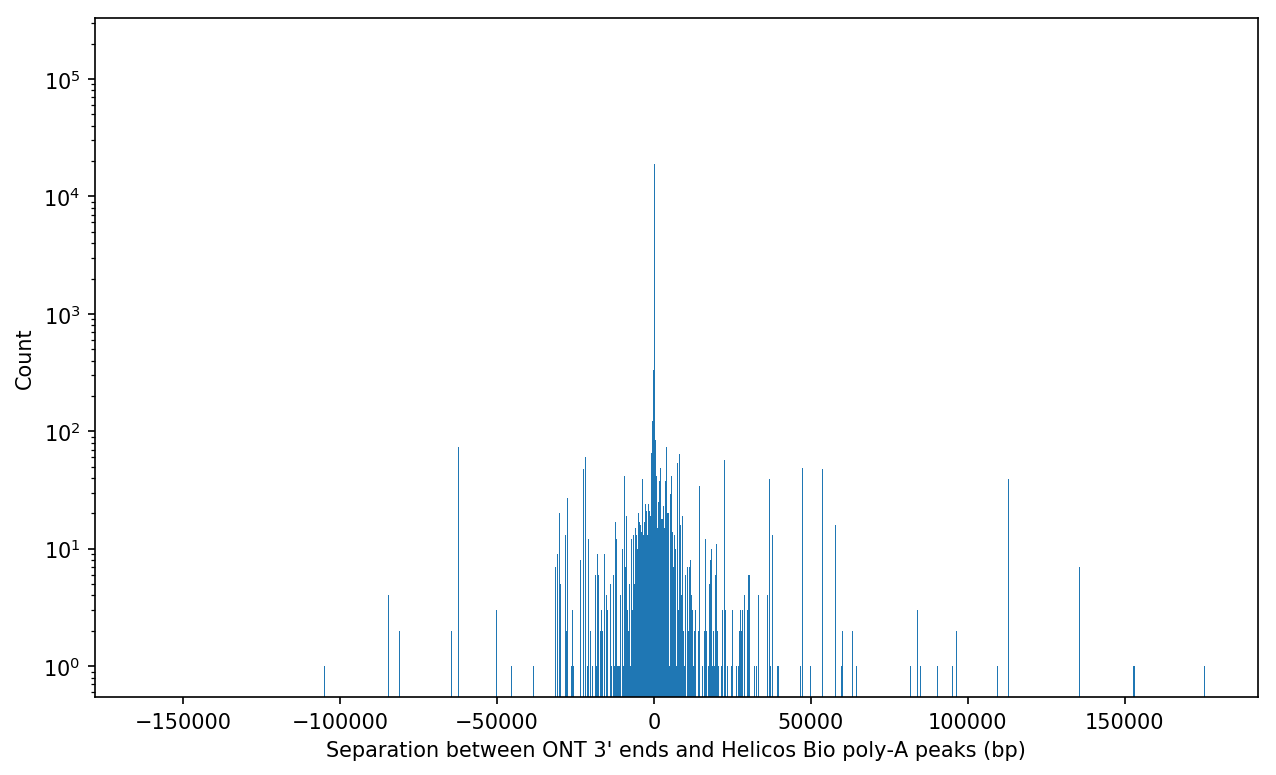

In [5]:
fig = plt.figure(figsize=(10,6), dpi=150)
x=plt.hist(deltas, bins=2000, cumulative=False, log=True)
plt.xlabel("Separation between ONT 3' ends and Helicos Bio poly-A peaks (bp)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

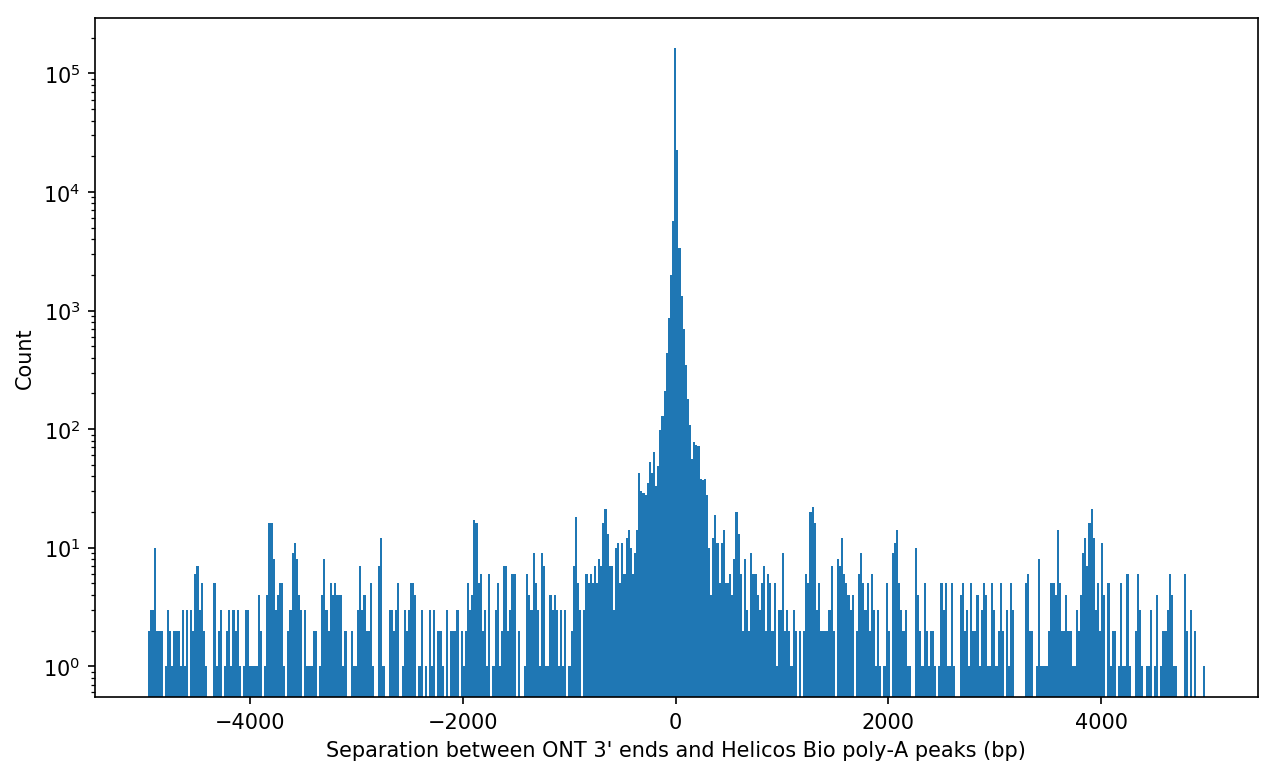

In [6]:
ind = (deltas>-5000)*(deltas<5000)
fig = plt.figure(figsize=(10,6), dpi=150)
x=plt.hist(deltas[ind], bins=500, cumulative=False, log=True)
plt.xlabel("Separation between ONT 3' ends and Helicos Bio poly-A peaks (bp)")
plt.ylabel("Count")

# Thresholding

Positions that are undetected in one dataset but detected in the other will naturally result in massive distandes upstream or downstream to their 'nearest' matching signal in the other dataset. Conversely, well detected 3' ends should cluster more tightly together. One hopes that the clustered ends will form a distribution (of sorts) with a characteristic standard deviation and in the missing data scenario thhe distance distribution is essentially uniform and will thus have a character standard deviation that grows 1-to-1 with the width of selected region. So, what we'll look for is how the standard deviation of the distribution changes with theshold distances and use the gradient of this curve to find a sensible transition point.

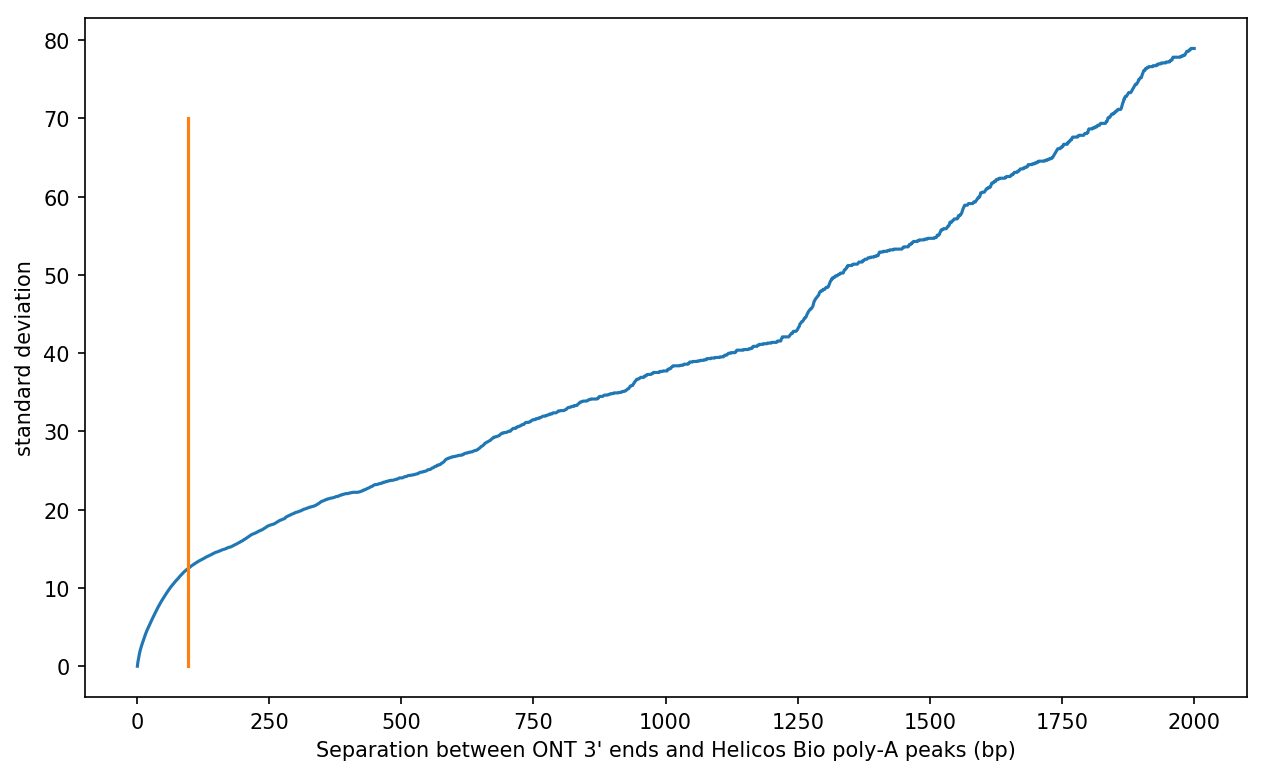

In [7]:
d=2000
step=1
stds=[]
ds=[]
while d>0:
    ind = (deltas>-1*d)*(deltas<d)
    stds.append(numpy.std(deltas[ind]))
    ds.append(d)
    d=d-step

stds = numpy.array(stds)[::-1]
ds=numpy.array(ds)[::-1]
dstds = numpy.gradient(stds)
# use the standard deviation of the gradients as the threhold rather than exactly zero 
# to account for noise
grad_threshold = numpy.std(dstds)
threshold = ds[numpy.where(dstds<grad_threshold)[0][0]] 

fig = plt.figure(figsize=(10,6), dpi=150)
x=plt.plot(ds, stds)
plt.xlabel("Separation between ONT 3' ends and Helicos Bio poly-A peaks (bp)")
plt.ylabel("standard deviation")
plt.plot([threshold,threshold],[0,70])

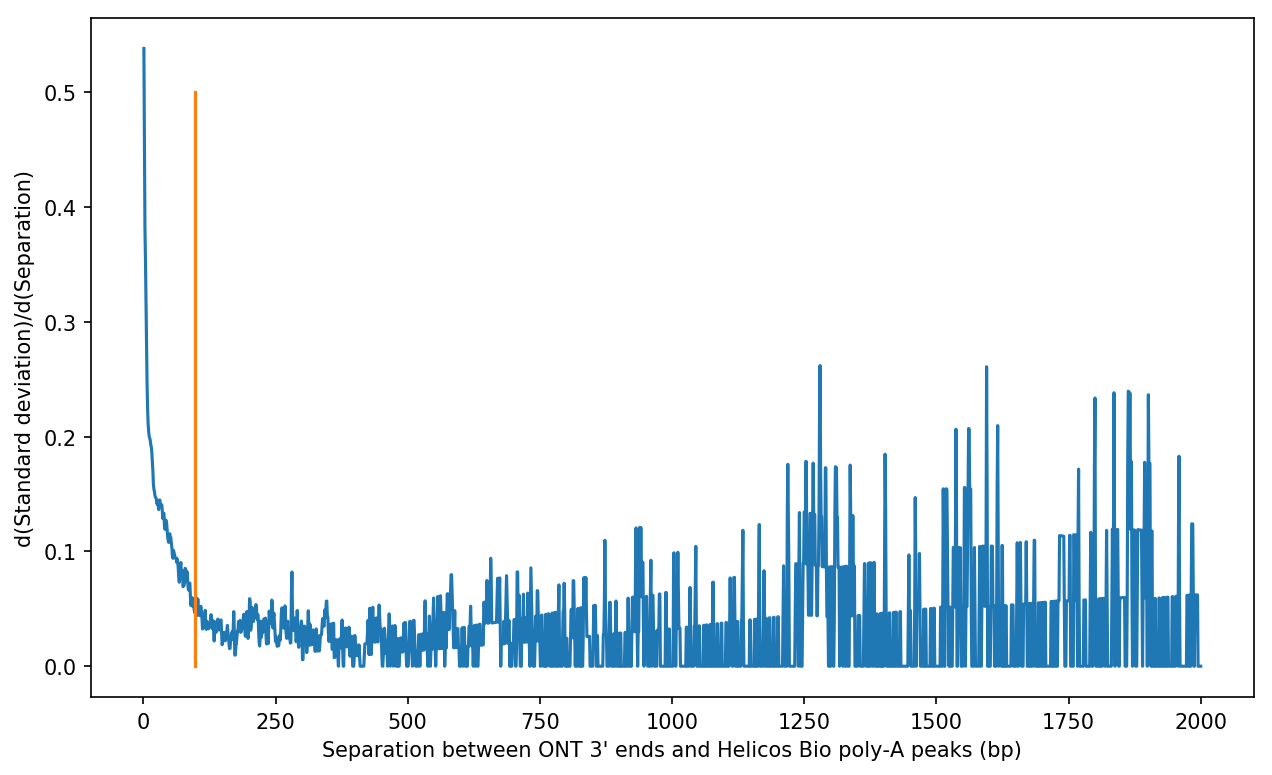

In [8]:
fig = plt.figure(figsize=(10,6), dpi=150)
x=plt.plot(ds, dstds)
plt.xlabel("Separation between ONT 3' ends and Helicos Bio poly-A peaks (bp)")
plt.ylabel("d(Standard deviation)/d(Separation)")
plt.plot([threshold,threshold],[0, 0.5])

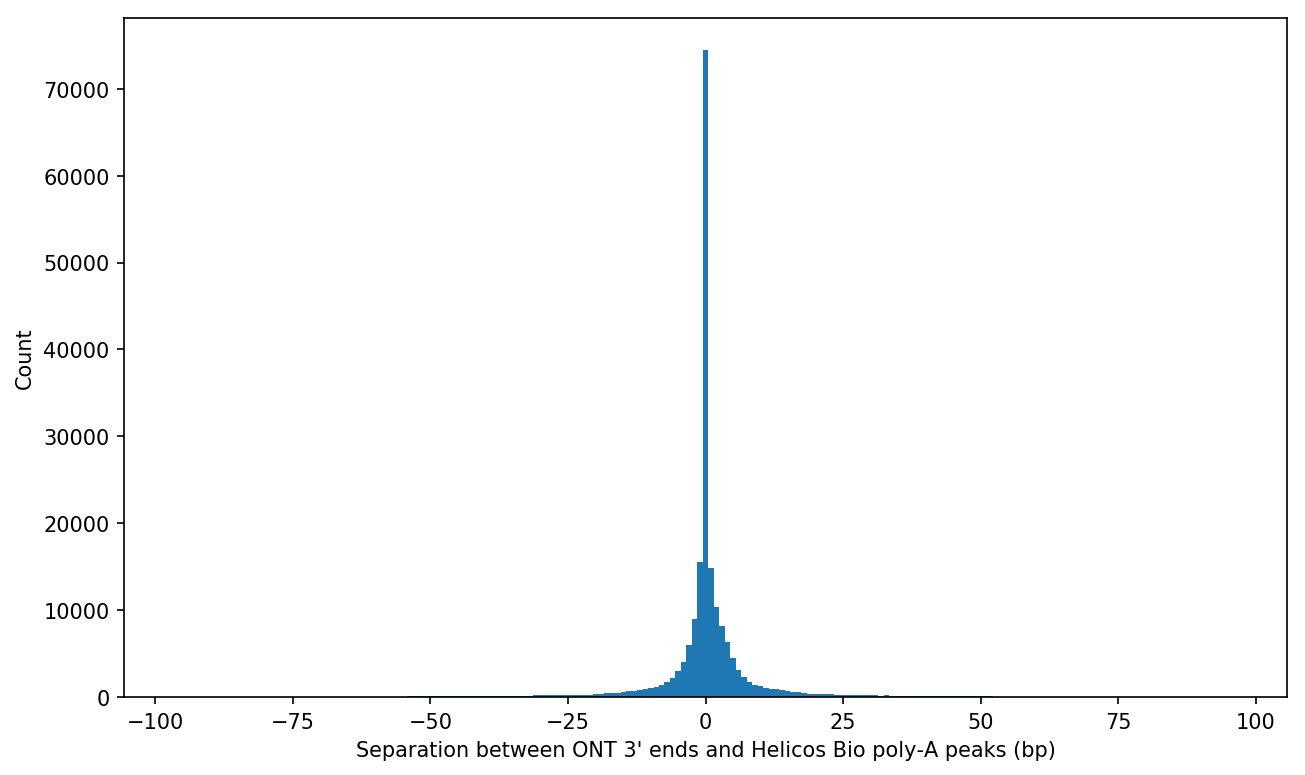

In [9]:
ind = (deltas>-threshold)*(deltas<threshold)
fig = plt.figure(figsize=(10,6), dpi=150)
x=plt.hist(deltas[ind], bins=(2*threshold)-1, cumulative=False,log=False)
plt.xlabel("Separation between ONT 3' ends and Helicos Bio poly-A peaks (bp)")
plt.ylabel("Count")
plt.savefig("../figures/Figure_05.png", dpi=300, transparent=True, format='png')
plt.savefig("../figures/Figure_05.svg", format='svg')

In [10]:
print("Mean separation:\t{:>4.1f}\nMedian separation:\t{:>4.1f}\nStandard deviation:\t{:>4.1f}".format(numpy.mean(deltas[ind]),
                                                                                                  numpy.median(deltas[ind]),
                                                                                                  numpy.std(deltas[ind])))

Mean separation:	 0.4
Median separation:	 0.0
Standard deviation:	12.5


In [13]:
nz = len(numpy.where(deltas[ind]==0)[0])
nnz = len(numpy.where(deltas[ind]!=0)[0])
print("Zero separation:\t{:>6d} ({:.2f}%)".format(nz, 100*nz/(nz+nnz)))
print("Non-zero separation:\t{:>6d} ({:.2f}%)".format(nnz, 100*nnz/(nz+nnz)))

Zero separation:	 74466 (37.28%)
Non-zero separation:	125290 (62.72%)
